In [1]:
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import numpy as np
from slsim.Sources.source import Source
from slsim.Deflectors.deflector import Deflector
from slsim.lens import Lens
from slsim.LOS.los_individual import LOSIndividual
from slsim.image_simulation import lens_image, rgb_image_from_image_list
from slsim.Util.param_util import gaussian_psf

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Single lens simulation
This notebook walks through the basics of simulating a galaxy-galaxy strong lens using users
own lens parameters.

The notebook goes in three steps:

1. Prepare source and deflector dict of your lens. 
2. Initialize Source, Deflector, and LOSIndividual class
3. Initialize Lens class
4. Use Lens class from 3 in image simulation module to simulate image

## Prepare source and deflector dict of your lens. 

In [2]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [3]:
# Source dict. You can also proviide magnitude in single band. This source dict is 
# valid for single sersic_ellipse light profile. 
source_dict={'z': 1.5,
  'angular_size': 0.10887651129362959, # effective radius of a source in arcsec
  'mag_g': 22.5, # g-band magnitude of a source
  'mag_r':22, # r-band magnitude of a source
  'mag_i': 22.2, # i-band magnitude of a source
  'mag_z': 22.1, # z-band magnitude of a source
  'mag_y': 22.0, # y-band magnitude of a source
  'e1': 0.0, # tangential component of the ellipticity
  'e2': 0.0, # cross component of the ellipticity
  'n_sersic': 1.5547096361698418, # sersic index for sersic_ellipse profile
  "center_x": 0.056053505877290584, # x-position of the center of a source
  "center_y": -0.08071283196326566} # y-position of the center of a source

# Deflector dict. You can also provide magnitude in single band. This deflector dict is
# valid for elliptical power law model. 
deflector_dict = {
    'z': 0.5,
    'angular_size': 0.09604418906529916,  # effective radius of the deflector in arcsec
    'mag_g': 20.0,  # g-band magnitude of a deflector
    'mag_r': 19.0, # r-band magnitude of a deflector
    'mag_i': 18.5,  # i-band magnitude of a deflector
    'mag_z': 18.0,  # z-band magnitude of a deflector
    'mag_y': 17.5,  # y-band magnitude of a deflector
    'theta_E': 2,  # Einstein radius of the deflector
    'e1_light': 0.09096489106609575,  # tangential component of the light ellipticity
    'e2_light': 0.1489400739802363,  # cross component of the light ellipticity
    'e1_mass': 0.1082427319496781,  # tangential component of the mass ellipticity
    'e2_mass': 0.10051583213026649,  # cross component of the mass ellipticity
    "gamma_pl": 2.0,  # power law slope in elliptical power law mass model
    'n_sersic': 2.4362388918558664,  # sersic index of a sersic_ellipse profile of a deflector
    "center_x": 0.10039720005025651,  # x-position of the center of the lens
    "center_y": -0.0002092046265491892  # y-position of the center of the lens
}

## Initialize Source, Deflector, and LOSIndividual class

In [4]:
source = Source(
                source_dict=source_dict,
                cosmo=cosmo,
                source_type="extended",
                light_profile="single_sersic",
            )
deflector = Deflector(
                deflector_type="EPL",
                deflector_dict=deflector_dict,
            )
los_class = LOSIndividual(kappa=0, gamma=[-0.005061965833762263, 0.028825761226555197])

## Initialize Lens class

In [5]:
# This is your lens. it contains all the information about your lensing configuration.
lens_class=Lens(source_class=source, deflector_class=deflector, cosmo=cosmo, los_class=los_class)

## Use Lens class from 3 in image simulation module to simulate image

In [6]:
# load your psf kernel and transform matrix.
psf_kernel = gaussian_psf(fwhm=0.9, delta_pix=0.2, num_pix=41)

# let's set pixel to angle transform matrix.
transform_matrix = np.array([[0.2, 0], [0, 0.2]])

# These numbers come from some random dp0 cutout variance map. User can use their values.
bkg_std_i=0.05774509, # i-band background noise
bkg_std_r=0.03247451 # r-band background noise
bkg_std_g = 0.028600888 # g-band background noise

## Simulate images in different bands

In [7]:
image_i=lens_image(
            lens_class=lens_class,
            band="i",
            mag_zero_point=27, #lsst coadd images have zero point magnitude of 27.
            num_pix=61,
            psf_kernel=psf_kernel,
            transform_pix2angle=transform_matrix,
            exposure_time=300, # one can provide None
            t_obs=None,
            std_gaussian_noise=bkg_std_i, # one can provide None
            with_source=True,
            with_deflector=True,
        )
image_r=lens_image(
        lens_class=lens_class,
        band="r",
        mag_zero_point=27,
        num_pix=61,
        psf_kernel=psf_kernel,
        transform_pix2angle=transform_matrix,
        exposure_time=300,
        t_obs=None,
        std_gaussian_noise=bkg_std_r,
        with_source=True,
        with_deflector=True,
    )

image_g=lens_image(
        lens_class=lens_class,
        band="g",
        mag_zero_point=27,
        num_pix=61,
        psf_kernel=psf_kernel,
        transform_pix2angle=transform_matrix,
        exposure_time=300, 
        t_obs=None,
        std_gaussian_noise=bkg_std_g,
        with_source=True,
        with_deflector=True,
)

In [8]:
# Simulate rgb color image
rgb_image = rgb_image_from_image_list([image_i, image_r, image_g], stretch=0.5)

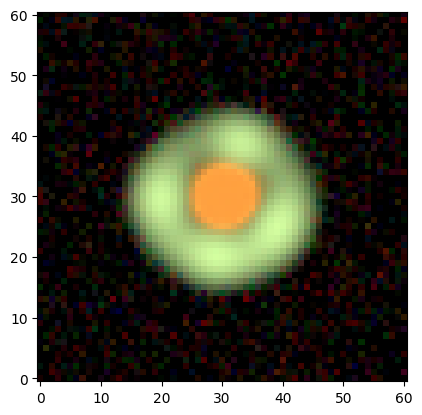

In [9]:
## see rgb image. You can also see images in each band.
plt.imshow(rgb_image, origin="lower")